# SIBUR competition baseline

In [1]:
# Импорт нужных библиотек и настройка глобальных параметров ноутбука
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
import bokeh
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', 500)
plt.rcParams['figure.figsize'] = (10,3)

targets = ['target', 'target2', 'target3', 'target4', 'target5']

In [2]:
# 1. read raw data
sensors = pd.read_csv('data/sensors.csv', parse_dates=['timestamp'], index_col='timestamp')
coke = pd.read_csv('data/coke_target.csv', parse_dates=['timestamp'], index_col='timestamp')
reactor_pressure = pd.read_csv('data/reactor_pressure_target.csv', parse_dates=['timestamp'], index_col='timestamp')

temp_on_he = pd.read_csv('data/temp_on_he_target.csv', parse_dates=['timestamp'], index_col='timestamp')
pressure_he = pd.read_csv('data/pressure_he_target.csv', parse_dates=['timestamp'], index_col='timestamp')
activity = pd.read_csv('data/activity_target.csv', parse_dates=['timestamp'], index_col='timestamp')

reactor_pressure.columns = ['target2']
temp_on_he.columns = ['target3']
pressure_he.columns = ['target4']
activity.columns = ['target5']

# 2. merge to one dataframe
merged_df = pd.merge(sensors, coke, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, reactor_pressure, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, temp_on_he, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, pressure_he, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, activity, on='timestamp', how='outer')

# 3. split to train and test data
train = merged_df[:'2018-01-01'].fillna(method='ffill').fillna(0)
X_test = merged_df.drop(targets, axis=1).fillna(method='ffill').dropna()['2018-01-01':]

In [3]:
width = 490
height = 200
df = train
graph1 = df.f_0.hvplot(width = width, height = height) + df.target3.hvplot(width = width, height = height) + \
        df.target.hvplot(width = width, height = height) + df.target4.hvplot(width = width, height = height) + \
        df.target2.hvplot(width = width, height = height) + df.target5.hvplot(width = width, height = height)
graph1.cols(2)

:Layout
   .Curve.F_0     :Curve   [timestamp]   (f_0)
   .Curve.Target3 :Curve   [timestamp]   (target3)
   .Curve.Target  :Curve   [timestamp]   (target)
   .Curve.Target4 :Curve   [timestamp]   (target4)
   .Curve.Target2 :Curve   [timestamp]   (target2)
   .Curve.Target5 :Curve   [timestamp]   (target5)

C:\Progs\Anaconda2\envs\Tensor\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


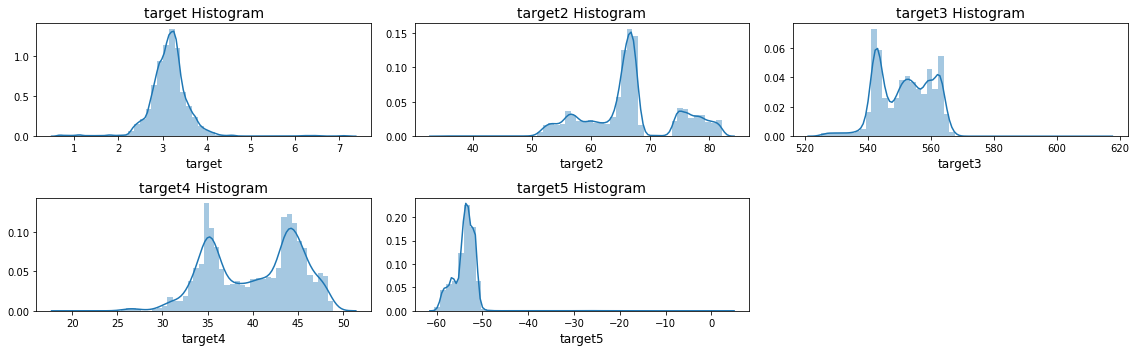

In [4]:
plt.figure(figsize=(16,5))
for i, tar in enumerate(targets):
    sns.distplot(df[tar].values, bins=50, kde=True, ax = plt.subplot(2, 3, i+1))
    plt.xlabel(tar, fontsize=12)
    plt.title(tar + ' Histogram', fontsize=14)

plt.tight_layout()
plt.show()

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

X_train = df.drop(targets, axis=1)
y_train = df[targets[0]]

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
gbr = GradientBoostingRegressor()

X_train = df.drop(targets, axis=1)
y_train = df[targets[0]]
scores=[]
full_prediction = []
for train_ind, test_ind in tscv.split(X_train):
    used_indexes = len(train_ind) + len(test_ind)
    gbr.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
    pred = gbr.predict(X_train.iloc[test_ind])
    
    # for drawing prediction
    full_prediction.append(np.concatenate([y_train[train_ind], pred, np.zeros(len(X_train) - used_indexes)]))
    
    score = MSE(y_train.iloc[test_ind], pred)**0.5
    scores.append(score)
    print('train len: ', len(train_ind), '\t till ', X_train.index[train_ind[-1]]  ,'\t score: ' , score)

print('average score: ', np.mean(scores))

train len:  954 	 till  2016-12-03 09:00:00 	 score:  0.3802939688525462
train len:  1901 	 till  2017-01-11 20:00:00 	 score:  0.7091185597527654
train len:  2848 	 till  2017-02-20 07:00:00 	 score:  0.47690398041195925
train len:  3795 	 till  2017-03-31 18:00:00 	 score:  0.9991259315473047
train len:  4742 	 till  2017-05-10 05:00:00 	 score:  0.3022290977323031
train len:  5689 	 till  2017-06-18 16:00:00 	 score:  0.37521186389437766
train len:  6636 	 till  2017-07-28 03:00:00 	 score:  0.32463816612843366
train len:  7583 	 till  2017-09-05 14:00:00 	 score:  0.9964271656462586
train len:  8530 	 till  2017-10-15 01:00:00 	 score:  0.3722710769583149
train len:  9477 	 till  2017-11-23 12:00:00 	 score:  0.309565389740923
average score:  0.5245785200665186


In [11]:
pred_df = pd.DataFrame(full_prediction[9], index=X_train.index)
pred_df.hvplot() * y_train.hvplot()

:Overlay
   .Curve.I      :Curve   [timestamp]   (0)
   .Curve.Target :Curve   [timestamp]   (target)

In [18]:
# Making a submission file #
sub_df = test['2018':]
sub_df['target_pred'] = gbr.predict(X_test)

sub_df['target_pred'].to_csv("baseline_gbr.csv", index=True, header=True)

#0.5562 оценка  RMSE
# 0.5248 - my score

In [118]:
def generator(features, data_targets, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(features) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, features.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = features[indices]
            targets[j] = data_targets[rows[j] + delay]
        yield samples, targets

In [119]:
lookback = 240
step = 6
delay = 10
batch_size = 120

validation_start_index = 8000

train_gen = generator(X_train.values, y_train.values, lookback=lookback, delay=delay, min_index=0, 
                      max_index=validation_start_index, shuffle=True, step=step, batch_size=batch_size)

val_gen = generator(X_train.values, y_train.values, lookback=lookback, delay=delay, min_index=validation_start_index + 1, 
                    max_index=None, step=step, batch_size=batch_size)

test_gen = generator(X_test.values, y_train.values, lookback=lookback, delay=delay, min_index=0, max_index=None, 
                     step=step, batch_size=batch_size)

val_steps = (len(X_train) - validation_start_index - lookback) // batch_size
test_steps = (len(X_test) - lookback) // batch_size

In [123]:
next(val_gen)[1]

array([3.02456357, 3.00083087, 2.96687401, 2.94022058, 2.92066568,
       2.89081504, 2.86308447, 2.83868171, 2.80403019, 2.78118726,
       2.80320637, 2.81615526, 2.83006969, 2.84103249, 2.85593481,
       2.86976916, 2.88234319, 2.90607941, 2.92305786, 2.93618036,
       2.94778416, 2.96382077, 2.94712377, 2.93055317, 2.91178454,
       2.89607622, 2.88858778, 2.86305678, 2.84780833, 2.83514161,
       2.80594641, 2.78799221, 2.78323747, 2.76124548, 2.77205993,
       2.78187678, 2.78451357, 2.80559171, 2.81647255, 2.8283    ,
       2.84149926, 2.86520884, 2.86598978, 2.87802949, 2.88446964,
       2.89615792, 2.88338823, 2.87515146, 2.86265639, 2.86590119,
       2.86019026, 2.84786873, 2.83791993, 2.83397441, 2.82182703,
       2.82137278, 2.80360633, 2.79856983, 2.81357333, 2.81042728,
       2.80874661, 2.80673997, 2.81859268, 2.81267277, 2.82116459,
       2.8254107 , 2.82906334, 2.83827414, 2.84077609, 2.83726264,
       2.84093066, 2.83746052, 2.8399688 , 2.83725097, 2.83365

In [26]:
def evaluate_naive_method():
    batch_maes = []
    total_len = 0
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        #mae = np.mean(np.abs(preds - targets))
        mae = MSE(preds, targets)**0.5
        batch_maes.append(mae)
        total_len += len(preds)
    print(np.mean(batch_maes))
    print(total_len)
    return preds

preds = evaluate_naive_method()

0.02191026158071127
2160


In [133]:
sample1 = pd.DataFrame(next(val_gen)[0][0], columns=X_train.columns)
sample2 = pd.DataFrame(next(val_gen)[0][1], columns=X_train.columns)
sample1.head(10)

f_0       f_1        f_2       f_3       f_4       f_5       f_6  \
0  99.170716  0.248085  26.033372  0.013755  0.537020  0.009014  0.869803   
1  99.170716  0.248085  26.033372  0.010410  0.594215 -0.027450  0.827590   
2  99.332440  0.234810  26.033372  0.003627  0.626318  0.003486  0.783130   
3  99.332440  0.234810  26.033372 -0.018262  0.576493 -0.018539  0.932892   
4  99.332440  0.234810  25.886193 -0.015448  0.541780  0.038806  0.831708   
5  99.332440  0.234810  25.886193  0.009726  0.628924  0.019712  1.028249   
6  99.104357  0.235028  25.886193  0.005086  0.623473  0.002447  0.747862   
7  99.104357  0.235028  25.886193 -0.012986  0.430626  0.017887  0.703686   
8  99.104357  0.235028  25.888988 -0.013602  0.593643  0.000370  0.829809   
9  99.104357  0.235028  25.888988 -0.019370  0.578810  0.019567  0.802397   

        f_7            f_8            f_9           f_10          f_11  \
0  2.905124  229007.324536  229675.497709  227507.046880  10414.714688   
1  2.119014  228085.356675  230648.099583  228707.339731  10439.647254   
2  4.197548  228039.189639  231130.116603  228426.589385  10461.893400   
3  3.573876  229612.346139  231886.356427  228684.987573  10496.951215   
4  0.137160  227978.936655  229105.250236  225952.835607  10423.825225   
5 -0.722343  227236.371074  227863.750789  226239.807754  10443.894784   
6 -4.502007  227016.389505  228917.476063  227331.357349  10286.174003   
7  1.014803  227056.627754  229914.285615  227423.140420  10300.225349   
8  9.640088  228355.823281  230943.968706  227513.194274  10209.463990   
9 -1.801084  227425.725864  229119.663822  227987.099440  10188.592910   

           f_12          f_13       f_14        f_15        f_16       f_17  \
0  10417.677274  10658.750711  46.716412  120.223269  131.664731  46.222601   
1  10399.653724  10634.761053  39.993854  119.490794  130.171169  46.024248   
2  10444.632403  10638.343993  45.977184  120.231291  131.485450  46.083130   
3  10523.179555  10718.463213  37.544768  120.934851  131.338119  46.381067   
4  10423.731384  10636.191898  42.674813  119.210280  130.291737  46.269539   
5  10392.354914  10623.952241  40.556407  119.563475  131.506729  46.208328   
6  10287.506441  10436.650003  47.638725  120.279152  130.855352  46.106987   
7  10323.903584  10434.346229  50.288445  120.271036  130.661804  45.922248   
8  10210.864698  10441.680988  43.113619  120.492040  131.530980  46.025769   
9  10174.488773  10430.372534  43.642467  120.298390  130.789164  46.456629   

         f_18        f_19        f_20        f_21       f_22        f_23  \
0  108.887033  131.402751  644.403134  646.759363  43.926161  108.700285   
1  108.808639  131.418501  645.114508  645.698203  44.210253  110.056742   
2  108.816414  131.290542  644.285540  645.207989  43.847532  107.918418   
3  109.254087  130.659294  644.117525  644.766774  43.900640  108.558734   
4  109.148324  131.644721  646.017154  648.478065  44.182612  107.045420   
5  108.408814  130.208668  645.738105  645.997034  44.127371  109.221605   
6  109.205034  131.404026  645.818848  645.450685  43.911556  108.524978   
7  108.861482  130.719026  645.264187  643.441880  44.024894  109.490041   
8  109.138450  131.182378  645.026103  645.321231  44.073144  110.241976   
9  108.966915  131.189588  644.928173  648.351792  44.036210  108.468037   

         f_24        f_25       f_26        f_27        f_28        f_29  \
0  130.225825  650.972680  41.877454  110.099821  629.725492  631.854601   
1  130.620529  647.900133  42.195827  112.758602  625.744665  633.701164   
2  131.344053  648.657815  41.919255  113.702048  628.536863  632.064195   
3  130.479764  649.273125  41.997335  114.184118  628.786045  630.022798   
4  131.461159  647.973318  42.057652  110.360230  626.504922  632.428240   
5  131.142249  650.288103  42.028260  110.233901  619.683579  633.804896   
6  130.962822  647.307182  41.909290  109.484755  627.400018  636.216968   
7  131.520053  649.447358  42.1

In [134]:
sample2.head(10)

f_0       f_1        f_2       f_3       f_4       f_5       f_6  \
0  99.171112  0.231971  25.782447 -0.008514  0.462808 -0.015923  0.643586   
1  99.353942  0.232021  25.782447  0.008947  0.489295 -0.048844  0.651609   
2  99.353942  0.232021  25.782447  0.010041  0.522520 -0.016178  0.818132   
3  99.353942  0.232021  26.111079 -0.004645  0.514310 -0.009806  0.633014   
4  99.353942  0.232021  26.111079  0.014732  0.540673 -0.011256  0.693854   
5  99.079555  0.249187  26.111079 -0.002571  0.525775  0.040611  0.613583   
6  99.079555  0.249187  26.111079 -0.014139  0.566406  0.111820  0.884895   
7  99.079555  0.249187  25.685584  0.006287  0.551856  0.131685  0.684194   
8  99.079555  0.249187  25.685584  0.001172  0.465247  0.003410  0.687831   
9  98.901024  0.257908  25.685584 -0.005632  0.497858  0.049907  0.765433   

        f_7            f_8            f_9           f_10          f_11  \
0 -0.339261  228057.759625  229481.374831  227242.970161  10210.070536   
1 -3.212337  228674.275752  229870.515806  227259.317484  10329.934848   
2  2.972256  226143.433319  229659.742115  227376.762874  10288.923239   
3  4.330631  228214.562115  229131.639159  227289.032812  10264.616854   
4  0.972761  228103.340580  229604.880296  228280.866063  10294.095641   
5  3.852636  227274.990523  229231.010175  227625.307024  10275.540386   
6  4.917853  229492.409628  230008.573356  227030.122789  10250.210219   
7  3.984077  227842.858136  230897.464468  228562.297481  10328.874158   
8  1.006220  228333.731204  228694.551927  228368.214359  10223.767582   
9  3.774616  227033.735267  230746.407990  227217.657971  10232.151517   

           f_12          f_13       f_14        f_15        f_16       f_17  \
0  10284.618741  10368.252029  51.829530  120.460305  131.011971  46.001207   
1  10319.567249  10437.849652  39.892139  120.384227  130.668373  46.062799   
2  10277.856180  10465.530644  43.604230  119.895923  130.714986  46.170271   
3  10283.125663  10458.765834  38.105651  120.642999  131.213315  46.541386   
4  10290.985106  10542.122549  48.139527  120.310610  129.638715  46.531041   
5  10284.993343  10439.330610  43.844795  121.316602  130.884403  46.422416   
6  10219.343882  10430.480213  43.372358  120.624612  131.233411  46.072949   
7  10296.544977  10512.993460  36.236343  121.116950  131.380669  45.979786   
8  10265.351307  10457.982045  39.375875  122.029737  130.178731  46.038794   
9  10216.473155  10455.698032  39.208393  121.057529  131.297516  45.939495   

         f_18        f_19        f_20        f_21       f_22        f_23  \
0  109.129035  130.415398  645.422854  644.202890  43.949292  108.480885   
1  108.788173  130.556843  644.262273  645.211145  44.149694  109.711230   
2  108.885535  130.308335  645.715897  647.173047  44.103961  111.076297   
3  109.484778  130.901309  645.096795  644.591316  44.052589  109.117506   
4  109.345411  130.148271  646.599590  646.654503  43.939914  110.836245   
5  108.980814  130.928237  645.201520  644.490638  43.991674  108.991402   
6  109.128503  131.043236  646.747834  649.375870  44.045543  107.976434   
7  109.037350  130.528063  645.832058  644.939101  43.881832  108.141239   
8  109.099004  130.551466  646.315570  646.078487  43.875654  109.116239   
9  108.928233  131.808966  646.095538  648.282505  44.110087  110.222954   

         f_24        f_25       f_26        f_27        f_28        f_29  \
0  129.939035  648.498650  42.242018  109.378937  630.604743  633.710082   
1  131.027526  647.685453  41.933727  111.296875  627.571952  631.523327   
2  131.301820  649.375107  42.101991  111.570740  623.264544  629.438736   
3  130.270034  648.877729  42.070454  113.763236  631.000747  632.172925   
4  130.675736  649.576891  41.751602  112.430666  631.910284  634.652064   
5  131.080091  647.230412  42.229755  107.191760  628.713505  633.521347   
6  131.327837  648.908076  42.148429  112.965796  631.875606  631.087875   
7  130.802460  649.436643  42.2

In [55]:
X_train.iloc[validation_start_index+120:].head(10)

f_0       f_1        f_2       f_3       f_4  \
timestamp                                                                 
2017-09-28 00:00:00  99.073952  0.259977  25.711712 -0.003346  0.599325   
2017-09-28 01:00:00  99.073952  0.259977  25.711712 -0.005008  0.493021   
2017-09-28 02:00:00  99.073952  0.259977  25.711712 -0.009481  0.547603   
2017-09-28 03:00:00  99.073952  0.259977  25.711712  0.002621  0.515193   
2017-09-28 04:00:00  99.073952  0.259977  25.711712 -0.003717  0.550759   
2017-09-28 05:00:00  99.073952  0.259977  25.711712  0.008287  0.506407   
2017-09-28 06:00:00  99.073952  0.259977  25.711712 -0.001822  0.486940   
2017-09-28 07:00:00  99.073952  0.259977  25.711712  0.007115  0.537319   
2017-09-28 08:00:00  99.085795  0.266339  25.711712  0.003243  0.542949   
2017-09-28 09:00:00  99.085795  0.266339  25.711712  0.007761  0.475710   

                          f_5       f_6       f_7            f_8  \
timestamp                                                          
2017-09-28 00:00:00  0.004773  0.703807  3.776220  226790.254662   
2017-09-28 01:00:00  0.047733  0.788695  5.424528  227966.951143   
2017-09-28 02:00:00 -0.009869  0.895594  6.098975  227594.636761   
2017-09-28 03:00:00  0.029059  0.914883  6.927027  227684.884643   
2017-09-28 04:00:00 -0.015905  0.866009  9.045689  227342.159607   
2017-09-28 05:00:00  0.014669  0.718830 -0.474774  227305.716600   
2017-09-28 06:00:00 -0.016726  0.690454 -4.369051  227507.917858   
2017-09-28 07:00:00  0.006468  0.944591  9.182397  227859.178429   
2017-09-28 08:00:00  0.004864  0.881709  4.081069  228361.682987   
2017-09-28 09:00:00  0.011741  0.832774  4.459319  228275.261913   

                               f_9           f_10          f_11          f_12  \
timestamp                                                                       
2017-09-28 00:00:00  229492.825728  225831.352099  10705.129361  10667.600481   
2017-09-28 01:00:00  230075.262307  227665.636322  10824.999480  10817.788612   
2017-09-28 02:00:00  229413.231353  227026.581123  10690.082969  10675.953178   
2017-09-28 03:00:00  229206.467243  227375.663741  10664.425225  10650.980015   
2017-09-28 04:00:00  230181.174309  228316.122091  10682.668656  10618.904144   
2017-09-28 05:00:00  228279.196063  227248.500013  10624.057966  10630.970227   
2017-09-28 06:00:00  229442.151686  227583.570638  10705.179650  10683.336516   
2017-09-28 07:00:00  229542.081034  227390.307788  10596.148702  10583.167704   
2017-09-28 08:00:00  230031.844743  227017.787210  10648.827238  10658.587974   
2017-09-28 09:00:00  229780.336211  227106.543003  10633.725668  10654.524264   

                             f_13       f_14        f_15        f_16  \
timestamp                                                              
2017-09-28 00:00:00  10857.526697  46.653965  118.418100  131.427683   
2017-09-28 01:00:00  11020.023574  48.045766  119.754798  131.920994   
2017-09-28 02:00:00  10819.167233  50.313333  118.709718  130.701193   
2017-09-28 03:00:00  10855.933679  47.577047  120.015727  130.267663   
2017-09-28 04:00:00  10828.695185  46.284137  119.082813  131.474810   
2017-09-28 05:00:00  10889.779511  50.893293  118.805547  130.207805   
2017-09-28 06:00:00  10859.388422  47.919743  118.888448  130.936107   
2017-09-28 07:00:00  10817.675499  52.569491  119.351068  131.465397   
2017-09-28 08:00:00  10847.428197  47.845800  119.308315  131.508359   
2017-09-28 09:00:00  10892.338232  54.276702  119.195696  131.012114   

                          f_17        f_18        f_19        f_20  \
timestamp                                                            
2017-09-28 00:00:00  46.101783  109.456186  131.851898  643.415304   
2017-09-28 01:00:00  46.066060  108.518445  130.901035  643.597530   
2017-09-28 02:00:00  46.001575  109.265060  131.253965  644.705734   
2017-09-28 03:00:00  45.970287  109.339750  131.063850  645.650507   
2017-09-28 04:00:00  46.045021  109.151785  131.427

In [127]:
train[(train.target>3.02456) & (train.target<3.02457)]

f_0      f_1        f_2       f_3      f_4      f_5  \
timestamp                                                                       
2017-10-08 11:00:00  99.33244  0.23481  26.033372 -0.007893  0.57998  0.00186   

                          f_6       f_7            f_8           f_9  \
timestamp                                                              
2017-10-08 11:00:00  0.971622 -2.448049  228087.171666  230761.95753   

                              f_10          f_11          f_12          f_13  \
timestamp                                                                      
2017-10-08 11:00:00  227357.790806  10426.997535  10520.260501  10690.238966   

                          f_14        f_15        f_16       f_17        f_18  \
timestamp                                                                       
2017-10-08 11:00:00  48.041914  119.688976  131.531632  46.291975  109.030542   

                          f_19        f_20        f_21       f_22        f_23  \
timestamp                                                                       
2017-10-08 11:00:00  131.27238  644.622765  645.644819  44.059318  108.038371   

                          f_24        f_25       f_26        f_27       f_28  \
timestamp                                                                      
2017-10-08 11:00:00  130.54575  648.433196  41.978063  109.600842  624.26475   

                           f_29        f_30        f_31       f_32      f_33  \
timestamp                                                                      
2017-10-08 11:00:00  631.984547  615.858733  652.215154  68.681243  8.640631   

                         f_34      f_35       f_36       f_37       f_38  \
timestamp                                                                  
2017-10-08 11:00:00  9.074965  8.459172  45.734233  50.020008  49.988039   

                          f_39      f_40      f_41      f_42          f_43  \
timestamp                                                                    
2017-10-08 11:00:00  49.848068  0.730678  0.023477 -0.012083  10717.449113   

                              f_44          f_45      f_46          f_47  \
timestamp                                                                  
2017-10-08 11:00:00  229969.368884  10474.020213  6.147197  62867.748533   

                       target    target2     target3    target4    target5  
timestamp                                                                   
2017-10-08 11:00:00  3.024564  74.799051  550.595488  43.847755 -51.646363

In [131]:
train.iloc[validation_start_index+370:]

f_0       f_1        f_2       f_3       f_4  \
timestamp                                                                 
2017-10-08 10:00:00  99.332440  0.234810  26.033372  0.009622  0.713335   
2017-10-08 11:00:00  99.332440  0.234810  26.033372 -0.007893  0.579980   
2017-10-08 12:00:00  99.332440  0.234810  26.033372  0.011245  0.612998   
2017-10-08 13:00:00  99.332440  0.234810  26.033372  0.003627  0.626318   
2017-10-08 14:00:00  99.332440  0.234810  26.033372  0.014778  0.641574   
2017-10-08 15:00:00  99.332440  0.234810  26.033372  0.011935  0.568049   
2017-10-08 16:00:00  99.332440  0.234810  26.033372 -0.019157  0.597147   
2017-10-08 17:00:00  99.332440  0.234810  26.033372  0.000102  0.515444   
2017-10-08 18:00:00  99.332440  0.234810  26.033372 -0.006895  0.549418   
2017-10-08 19:00:00  99.332440  0.234810  26.033372 -0.018262  0.576493   
2017-10-08 20:00:00  99.332440  0.234810  25.886193 -0.000709  0.556997   
2017-10-08 21:00:00  99.332440  0.234810  25.886193 -0.012235  0.553077   
2017-10-08 22:00:00  99.332440  0.234810  25.886193 -0.015859  0.477419   
2017-10-08 23:00:00  99.332440  0.234810  25.886193 -0.015422  0.550066   
2017-10-09 00:00:00  99.332440  0.234810  25.886193 -0.009151  0.533908   
2017-10-09 01:00:00  99.332440  0.234810  25.886193 -0.015448  0.541780   
2017-10-09 02:00:00  99.332440  0.234810  25.886193  0.025872  0.568826   
2017-10-09 03:00:00  99.332440  0.234810  25.886193 -0.011639  0.571028   
2017-10-09 04:00:00  99.332440  0.234810  25.886193 -0.021836  0.532733   
2017-10-09 05:00:00  99.332440  0.234810  25.886193 -0.007690  0.590844   
2017-10-09 06:00:00  99.332440  0.234810  25.886193  0.004877  0.607060   
2017-10-09 07:00:00  99.332440  0.234810  25.886193  0.009726  0.628924   
2017-10-09 08:00:00  99.104357  0.235028  25.886193  0.003515  0.546217   
2017-10-09 09:00:00  99.104357  0.235028  25.886193 -0.005758  0.584377   
2017-10-09 10:00:00  99.104357  0.235028  25.886193  0.000667  0.581769   
2017-10-09 11:00:00  99.104357  0.235028  25.886193 -0.007214  0.544478   
2017-10-09 12:00:00  99.104357  0.235028  25.886193 -0.015982  0.578498   
2017-10-09 13:00:00  99.104357  0.235028  25.886193  0.005086  0.623473   
2017-10-09 14:00:00  99.104357  0.235028  25.886193  0.013080  0.581901   
2017-10-09 15:00:00  99.104357  0.235028  25.886193  0.029795  0.546270   
...                        ...       ...        ...       ...       ...   
2017-12-31 18:00:00  99.260621  0.207408  26.979203 -0.014799  0.418652   
2017-12-31 19:00:00  99.260621  0.207408  26.979203 -0.006919  0.368352   
2017-12-31 20:00:00  99.260621  0.207408  26.085341  0.001385  0.338116   
2017-12-31 21:00:00  99.260621  0.207408  26.085341  0.003392  0.451943   
2017-12-31 22:00:00  99.260621  0.207408  26.085341 -0.000594  0.405331   
2017-12-31 23:00:00  99.260621  0.207408  26.085341 -0.000776  0.389252   
2018-01-01 00:00:00  99.260621  0.207408  26.085341 -0.003372  0.473979   
2018-01-01 01:00:00  99.260621  0.207408  26.085341  0.027597  0.487578   
2018-01-01 02:00:00  99.260621  0.207408  26.085341  0.021656  0.366576   
2018-01-01 03:00:00  99.260621  0.207408  26.085341  0.000592  0.351894   
2018-01-01 04:00:00  99.260621  0.207408  26.085341  0.004220  0.250062   
2018-01-01 05:00:00  99.260621  0.207408  26.085341 -0.008626  0.391674   
2018-01-01 06:00:00  99.260621  0.207408  26.085341  0.003529  0.484099   
2018-01-01 07:00:00  99.260621  0.207408  26.085341  0.001669  0.488488   
2018-01-01 08:00:00  98.898897  0.515878  26.085341  0.014630  0.222531   
2018-01-01 09:00:00  98.898897  0.515878  26.085341  0.004418  0.359840   
2018-01-01 10:00:00  98.898897  0.515878  26.085341 -0.016558  0.441084   
2018-01-01 11:00:00  98.898897  0.515878  26.085341 -0.014237  0.402673   
2018-01-01 12:00:00  98.898897  0.515878  26.085341 -0.017106  0.292600   
2018-01-01 13:00:00  98.898897  0.515878  26.085341 -0.016969  0.448701   
2018-01-01 14:00:00  98.898897  0.515878  26.085341 